In [7]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

import matplotlib.pyplot as plt

import pyro
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam
from pyro.infer.autoguide import AutoDiagonalNormal, AutoMultivariateNormal, AutoLowRankMultivariateNormal
from pyro.infer import Predictive
from pyro.nn import DenseNN

import numpy as np

import matplotlib.pyplot as plt

import os

from TurbulenceNetwork import TurbulenceNetworkBayesian
from TurbulenceClosureDataGenerator import TurbulenceClosureDataGenerator
from plot_utils import plot_data_generation_diff, plot_heat_map_compare, plot_heat_map_loss, plot_heat_map_3D
from Model_utils import *
from Data_utils import *


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data Generation

/home/codygrogan/PythonProjects/Uncertainty_Quantification/TurbulenceClosureDataGenerator.py:85: RuntimeWarning: invalid value encountered in arccos
  theta = np.arccos((-b/2)*np.sqrt(-a**3/27))


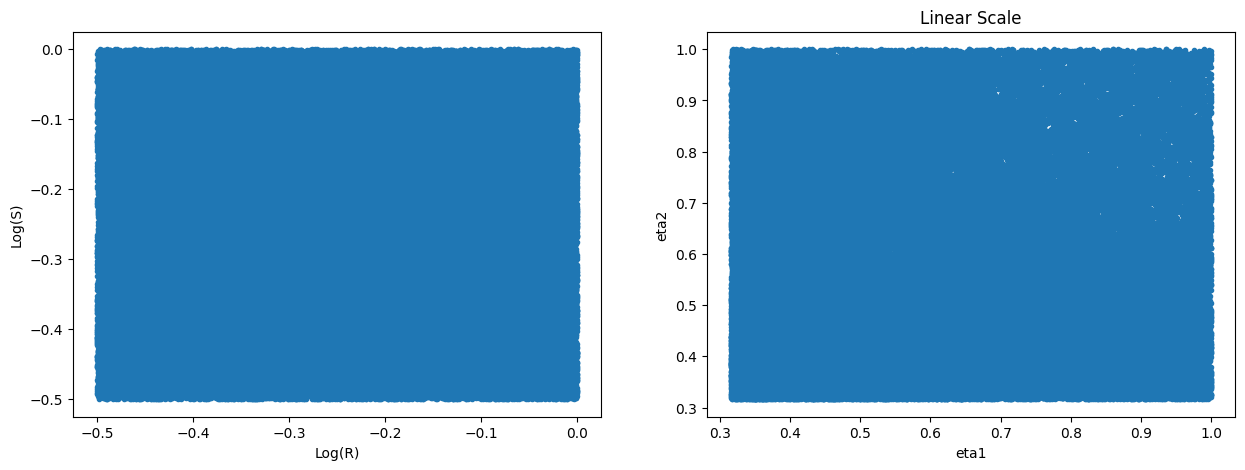

In [8]:
# Data generators for the different turbulence closures
SSG_gen = TurbulenceClosureDataGenerator('SSG')

# Defining the ranges for the different scales
log = (-.5, 0)

# Defining whether to exclude certain areas of the data
exclude_area = False
include_area = False
drop_eta_1 = False
drop_eta_2 = False
add_noise = False

# Defining area to exclude datapoints
eta_1_range = (10**np.array([-.3, 0.0]))**2
eta_2_range = (10**np.array([-.3, 0.0]))**2

etas_train, gs_train = generate_log_data(SSG_gen, log, 100_000, shuffle=True, gen_type="All")

etas_test, gs_test = generate_log_data(SSG_gen, log, 40_000, shuffle=True, gen_type="All")

if not drop_eta_1 and not drop_eta_2:
    plot_data_generation_diff(np.log10(np.sqrt(etas_train)))




## Training Parameters

In [18]:
model = TurbulenceNetworkBayesian(
    input_dim = 2,
    output_dim= 3,
    h_nodes = 100,
    layers = 6,
    data_size=etas_train.shape[0],
    layer_prior=torch.tensor([0., 3.], device=device),
    device=device,
    output_prior=torch.tensor([.05], device=device),
).to(device)


guide = AutoDiagonalNormal(model)

adam = Adam({"lr": 0.001})
svi = SVI(model, guide, adam, loss=Trace_ELBO(num_particles=4))

## Defining Datasets

In [14]:
x_train = torch.tensor(etas_train, dtype=torch.float32)
y_train = torch.tensor(gs_train, dtype=torch.float32)

train_loader = DataLoader(TensorDataset(x_train, y_train), batch_size=512, shuffle=True)

x_test = torch.tensor(etas_test, dtype=torch.float32).to(device)
y_test = torch.tensor(gs_test, dtype=torch.float32).to(device)

In [19]:
pyro.clear_param_store()

n_epochs = 100000

for epoch in range(n_epochs):
    loss = 0
    for bx_train, by_train in train_loader:
        bx_train = bx_train.to(device)
        by_train = by_train.to(device)
        loss += svi.step(bx_train, by_train)

    if epoch % 5 == 0:
        test_loss = svi.evaluate_loss(x_test, y_test)
        print(f"Epoch {epoch:8d} Test loss: {test_loss:.4f}, Train loss: {loss:.4f}")

Epoch        0 Test loss: 1294157.0283, Train loss: 1388111780.4936
Epoch        5 Test loss: 198483.1504, Train loss: 49037339.8803
Epoch       10 Test loss: -6356.0940, Train loss: 15816660.4540


KeyboardInterrupt: 

tensor(0.0094, dtype=torch.float64)


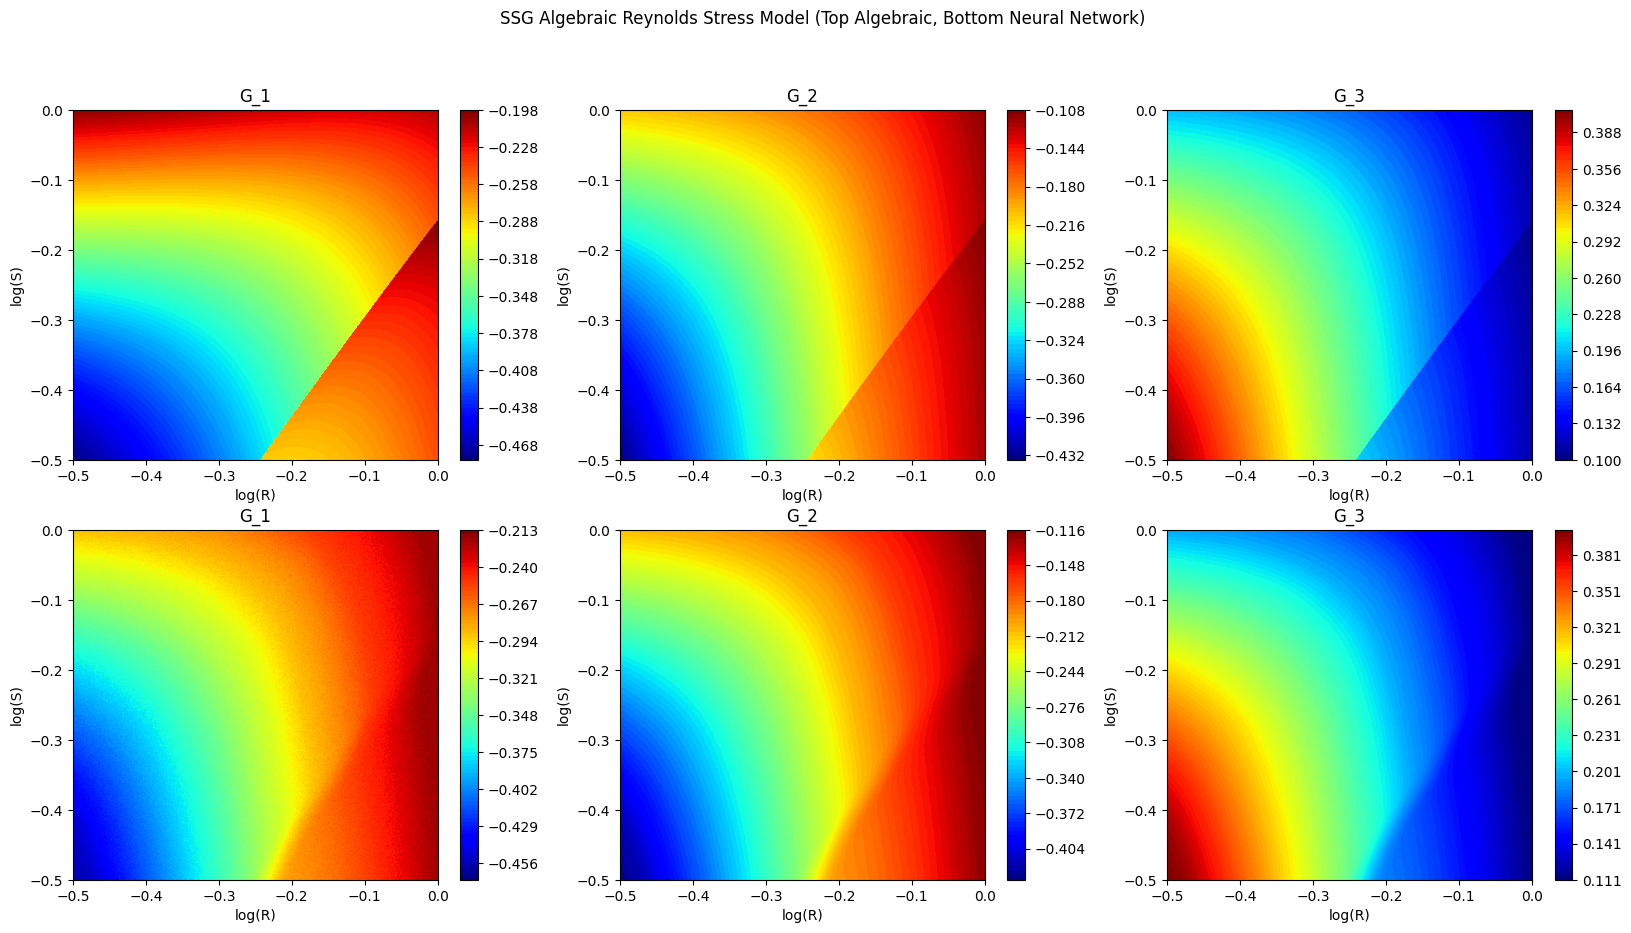

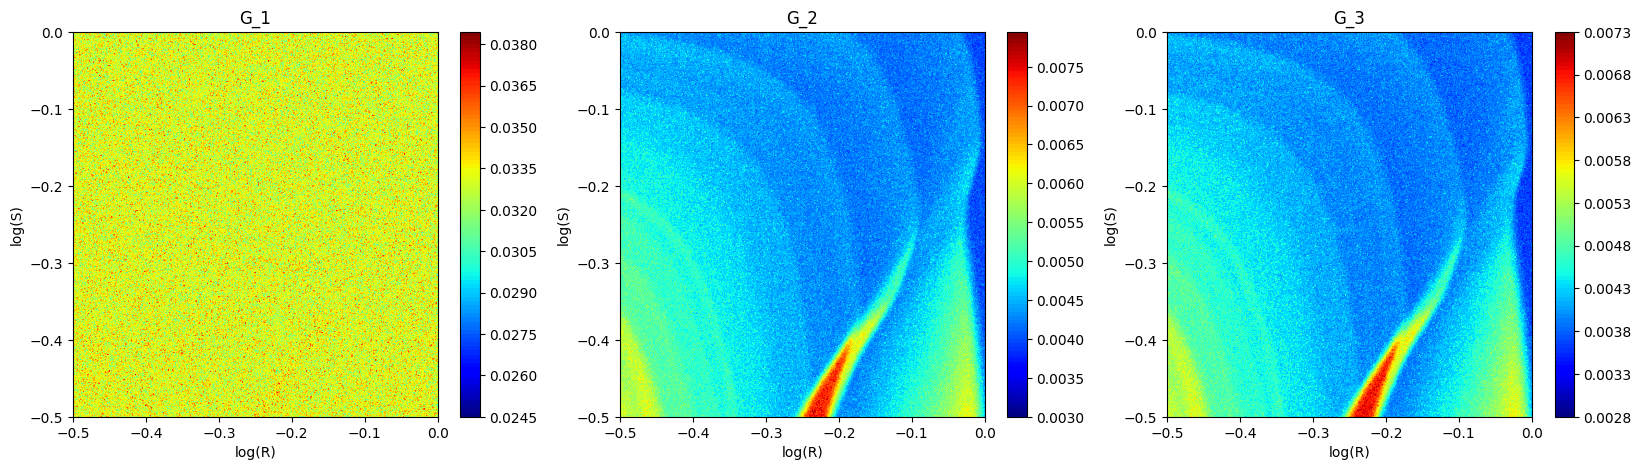

In [17]:
dim = 700
x_grid, y_grid = np.meshgrid(np.linspace(*log, dim),np.linspace(*log, dim))
eta1 = (10**x_grid.flatten())**2
eta2 = (10**y_grid.flatten())**2

gen = TurbulenceClosureDataGenerator(model="SSG", type='torch')
etas, G_s = gen(eta1, eta2)
target = G_s

model.data_size = etas.shape[0]

predictive = Predictive(model, guide=guide, num_samples=200, return_sites=("obs",))

pred = predictive(torch.tensor(etas, dtype=torch.float32).to(device))

pred_mean = torch.mean(pred["obs"], axis=0).detach().cpu()
pred_std = torch.std(pred["obs"], axis=0).detach().cpu()


print(torch.mean(torch.abs(torch.tensor(target) - pred_mean)))

plot_heat_map_compare(x_grid, y_grid, target.T.reshape(3, dim, dim), pred_mean.T.reshape(3, dim, dim))

plot_heat_map_3D(x_grid, y_grid, pred_std.T.reshape(3, dim, dim))